In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os

from dotenv import load_dotenv
import itertools

# Data Processing

In [2]:
# env variables
load_dotenv()
# edit the environment file to your datafile
data_path = os.environ.get("data_path")

In [3]:
data_path

'C:\\Users\\orcal\\Documents\\UCB\\CE295\\Project\\data'

In [4]:
os.chdir(data_path)
df_tx = pd.read_csv('15minute_data_austin.csv')
#df_ca = pd.read_csv('15minute_data_california.csv') not using for our project
df_ny = pd.read_csv('15minute_data_newyork.csv')

In [5]:
def clean_up_dataset(dataframe):
    sorted_df = dataframe.sort_values(by= ['local_15min'])
    all_sorted_time = sorted_df['local_15min'].unique()
    time_ids = {}
    unique_ids = {}
    counter = 0
    dataframe = dataframe.fillna(0)
    
    # Assign a unique numerical id to each timestamp
    for i in all_sorted_time:
        time_ids.update({i: counter})
        unique_ids.update({counter: i})
        counter += 1

    
    def get_front_back(df, date):
        if time_ids[date] - 1 > 0:
            back = unique_ids[time_ids[date] - 1]
        else:
            back = date
        if time_ids[date] + 1 < len(unique_ids):
            front = unique_ids[time_ids[date] + 1]
        else:
            front = date
        return (df[df['local_15min'] == front]['grid'], df[df['local_15min'] == back]['grid'])
    
    def missing_times(lst1, lst2):
        # takes unique list and finds the difference in other list
        return list(set(lst1).difference(lst2))
    
    # Append missing data values
    time_labels = []
    grid_interpret = []
    data_labels =[]
    num_uid = 0
    for k in dataframe['dataid'].unique():
        num_uid += 1
        cur_mis = missing_times(all_sorted_time, dataframe[dataframe['dataid'] == k]['local_15min'].unique())
        print(f"Household ID {k} is missing {len(cur_mis)} timestamps.")
        for j in cur_mis:
            time_labels += [j]
            grid_interpret += [np.nan]
            data_labels += [k]
            
    sorted_id = dataframe.append(pd.DataFrame({'local_15min': time_labels, 'grid': grid_interpret, 'dataid': data_labels}),
                    ignore_index = True)
    
    # Resort by data labels
    sorted_id = sorted_id.sort_values(by= ['dataid'])
    sorted_id.reset_index(drop=True,inplace=True)

    # Apply interpolation by indexing into separate UIDs
    df_list = []
    for uid in sorted_id['dataid'].unique():
        grid_pts = sorted_id.loc[sorted_id['dataid']==uid,:].copy()
        grid_pts = grid_pts.sort_values(by=['local_15min'],ignore_index=True)
        interp = grid_pts.interpolate(method='polynomial',order = 5)
        df_list.append(interp)
      
    sorted_id = pd.concat(df_list,ignore_index=True)
    return sorted_id

In [6]:
sorted_cleaned_tx = clean_up_dataset(df_tx)
# sorted_cleaned_ca = clean_up_dataset(df_ca)
sorted_cleaned_ny = clean_up_dataset(df_ny)

Household ID 661 is missing 4 timestamps.
Household ID 1642 is missing 388 timestamps.
Household ID 2335 is missing 568 timestamps.
Household ID 2361 is missing 52 timestamps.
Household ID 2818 is missing 56 timestamps.
Household ID 3039 is missing 0 timestamps.
Household ID 3456 is missing 104 timestamps.
Household ID 3538 is missing 0 timestamps.
Household ID 4031 is missing 0 timestamps.
Household ID 4373 is missing 504 timestamps.
Household ID 4767 is missing 77 timestamps.
Household ID 5746 is missing 300 timestamps.
Household ID 6139 is missing 0 timestamps.
Household ID 7536 is missing 52 timestamps.
Household ID 7719 is missing 156 timestamps.
Household ID 7800 is missing 16 timestamps.
Household ID 7901 is missing 144 timestamps.
Household ID 7951 is missing 0 timestamps.
Household ID 8156 is missing 52 timestamps.
Household ID 8386 is missing 0 timestamps.
Household ID 8565 is missing 0 timestamps.
Household ID 9019 is missing 108 timestamps.
Household ID 9160 is missing 32 t

In [7]:
def get_date(date):
    if type(date) == str:
        dtobj = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S-%f')
        return dtobj.year * 10000 + dtobj.month * 100 + dtobj.day
    return date.year * 10000 + date.month * 100 + date.day

def all_days(df):
    days = []
    i = 96
    while i < len(df):
        days.append(get_date(df.iloc[i-1]['local_15min']))
    return days

In [8]:
def multi_index_dataframe(df):
    df_days_all = df[df['dataid'] == df['dataid'][0]]['local_15min']
    df_days = []
    i = 96
    while i < len(df_days_all):
        df_days += [get_date(df_days_all[i-1])]
        i += 96
    iterables = [df['dataid'].unique(), df_days]
    multi_index = pd.MultiIndex.from_product(iterables, names=["dataid", "date"])    
    vals = []
    for houseid in df['dataid'].unique():
        temp = df[df['dataid'] == houseid]
        temp_dict = {}
        i = 96
        while i < len(temp):
            vals_temp = list(temp[i - 96:i]['grid'])
            vals += [vals_temp]
            i += 96
    df_final = pd.DataFrame(vals, index = multi_index, columns = np.arange(96))
    return df_final

In [9]:
multi_tx = multi_index_dataframe(sorted_cleaned_tx)

In [10]:
multi_ny = multi_index_dataframe(sorted_cleaned_ny)

In [11]:
multi_ny.head()

0      1      2      3      4      5      6      7   \
dataid date                                                               
27     20190501  0.997  0.750  0.608  1.057  0.518  1.163  0.591  1.155   
       20190502  0.300  0.275  0.296  0.836  0.248  0.269  0.753  0.374   
       20190503  0.352  0.355  0.265  0.219  0.304  0.342  0.336  0.301   
       20190504  0.408  0.311  0.359  0.364  0.266  0.209  0.303  0.413   
       20190505  0.544  0.503  0.781  0.368  0.901  0.369  0.658  0.600   

                    8      9   ...     86     87     88     89     90     91  \
dataid date                    ...                                             
27     20190501  0.840  0.697  ...  0.557  1.052  0.561  0.596  0.284  0.394   
       20190502  0.249  0.374  ...  0.741  0.830  0.749  0.703  0.224  0.233   
       20190503  0.304  0.304  ...  0.666  0.477  0.331  0.331  0.316  0.316   
       20190504  0.290  0.209  ...  1.449  0.782  2.082  1.291  1.140  0.811   
       20190505  0.440  0.808  ...  1.196  0.677  0.859  0.458  0.599  0.507   

                    92     93     94     95  
dataid date                                  
27     20190501  0.356  0.219  0.605  0.304  
       20190502  0.355  0.409  0.294  0.260  
       20190503  0.231  0.277  0.361  0.376  
       20190504  0.592  1.059  0.969  0.665  
       20190505  0.564  0.669  0.540  0.631  

[5 rows x 96 columns]

In [12]:
multi_tx_weekday = pd.to_datetime(multi_tx.reset_index()["date"], format= "%Y%M%d").dt.weekday
multi_tx_building = multi_tx.reset_index()["dataid"]
multi_tx_building.index, multi_tx_weekday.index = multi_tx.index, multi_tx.index
multi_tx_temp = multi_tx.copy()
multi_tx_temp["building"], multi_tx_temp["DOW"] = multi_tx_building, multi_tx_weekday
multi_tx_temp = multi_tx_temp.groupby(["building","DOW"])\
    .apply(lambda x: x / np.max(abs(x)))\
    .drop(["building", "DOW"], axis=1)
multi_tx_temp.head()
multi_tx = multi_tx[(abs(multi_tx)<25).sum(axis=1)==96]


In [13]:
multi_ny_weekday = pd.to_datetime(multi_ny.reset_index()["date"], format= "%Y%M%d").dt.weekday
multi_ny_building = multi_ny.reset_index()["dataid"]
multi_ny_building.index, multi_ny_weekday.index = multi_ny.index, multi_ny.index
multi_ny_temp = multi_ny.copy()
multi_ny_temp["building"], multi_ny_temp["DOW"] = multi_ny_building, multi_ny_weekday
multi_ny_temp.head()

0      1      2      3      4      5      6      7  \
dataid date                                                               
27     20190501  0.997  0.750  0.608  1.057  0.518  1.163  0.591  1.155   
       20190502  0.300  0.275  0.296  0.836  0.248  0.269  0.753  0.374   
       20190503  0.352  0.355  0.265  0.219  0.304  0.342  0.336  0.301   
       20190504  0.408  0.311  0.359  0.364  0.266  0.209  0.303  0.413   
       20190505  0.544  0.503  0.781  0.368  0.901  0.369  0.658  0.600   

                     8      9  ...     88     89     90     91     92     93  \
dataid date                    ...                                             
27     20190501  0.840  0.697  ...  0.561  0.596  0.284  0.394  0.356  0.219   
       20190502  0.249  0.374  ...  0.749  0.703  0.224  0.233  0.355  0.409   
       20190503  0.304  0.304  ...  0.331  0.331  0.316  0.316  0.231  0.277   
       20190504  0.290  0.209  ...  2.082  1.291  1.140  0.811  0.592  1.059   
       20190505  0.440  0.808  ...  0.859  0.458  0.599  0.507  0.564  0.669   

                    94     95  building  DOW  
dataid date                                   
27     20190501  0.605  0.304        27    1  
       20190502  0.294  0.260        27    2  
       20190503  0.361  0.376        27    3  
       20190504  0.969  0.665        27    4  
       20190505  0.540  0.631        27    5  

[5 rows x 98 columns]

In [14]:
multi_ny_temp = multi_ny_temp.groupby(["building","DOW"])\
    .apply(lambda x: x / np.max(abs(x)))\
    .drop(["building", "DOW"], axis=1)

In [15]:
multi_ny_temp.head()

0         1         2         3         4         5   \
dataid date                                                                   
27     20190501  0.274656  0.201505  0.158127  0.318758  0.388597  0.594885   
       20190502  0.075019  0.175159  0.244224  0.787194  0.319588  0.291757   
       20190503  0.231579  0.280411  0.192308  0.184810  0.212736  0.285000   
       20190504  0.094686  0.074886  0.098034  0.099075  0.071237  0.058658   
       20190505  0.302054  0.486460  0.438272  0.349810  0.806625  0.176978   

                       6         7         8         9   ...        86  \
dataid date                                              ...             
27     20190501  0.438753  0.683028  0.611354  0.373126  ...  0.122958   
       20190502  0.703081  0.419753  0.236019  0.359270  ...  0.180556   
       20190503  0.246334  0.272152  0.175014  0.251032  ...  0.158534   
       20190504  0.233256  0.397115  0.203509  0.141503  ...  0.337920   
       20190505  0.642578  0.381679  0.402194  0.602535  ...  0.193653   

                       87        88        89        90        91        92  \
dataid date                                                                   
27     20190501  0.282492  0.143149  0.143511  0.052399  0.075857  0.078901   
       20190502  0.189671  0.181796  0.167541  0.050496  0.059728  0.079259   
       20190503  0.111241  0.076549  0.074482  0.071542  0.075454  0.055905   
       20190504  0.194431  0.547463  0.346020  0.338782  0.645701  0.395458   
       20190505  0.140778  0.192687  0.116037  0.139790  0.124143  0.138882   

                       93        94        95  
dataid date                                    
27     20190501  0.046725  0.104708  0.067541  
       20190502  0.097894  0.066546  0.092231  
       20190503  0.066715  0.086096  0.087605  
       20190504  0.838480  0.773962  0.621495  
       20190505  0.154754  0.143122  0.145593  

[5 rows x 96 columns]

In [16]:
multi_ny.head()

0      1      2      3      4      5      6      7   \
dataid date                                                               
27     20190501  0.997  0.750  0.608  1.057  0.518  1.163  0.591  1.155   
       20190502  0.300  0.275  0.296  0.836  0.248  0.269  0.753  0.374   
       20190503  0.352  0.355  0.265  0.219  0.304  0.342  0.336  0.301   
       20190504  0.408  0.311  0.359  0.364  0.266  0.209  0.303  0.413   
       20190505  0.544  0.503  0.781  0.368  0.901  0.369  0.658  0.600   

                    8      9   ...     86     87     88     89     90     91  \
dataid date                    ...                                             
27     20190501  0.840  0.697  ...  0.557  1.052  0.561  0.596  0.284  0.394   
       20190502  0.249  0.374  ...  0.741  0.830  0.749  0.703  0.224  0.233   
       20190503  0.304  0.304  ...  0.666  0.477  0.331  0.331  0.316  0.316   
       20190504  0.290  0.209  ...  1.449  0.782  2.082  1.291  1.140  0.811   
       20190505  0.440  0.808  ...  1.196  0.677  0.859  0.458  0.599  0.507   

                    92     93     94     95  
dataid date                                  
27     20190501  0.356  0.219  0.605  0.304  
       20190502  0.355  0.409  0.294  0.260  
       20190503  0.231  0.277  0.361  0.376  
       20190504  0.592  1.059  0.969  0.665  
       20190505  0.564  0.669  0.540  0.631  

[5 rows x 96 columns]

In [17]:
multi_ny.xs(20190501,level = 1).index

Int64Index([  27,  142,  387,  558,  914,  950, 1222, 1240, 1417, 2096, 2318,
            2358, 3000, 3488, 3517, 3700, 3996, 4283, 4550, 5058, 5587, 5679,
            5982, 5997, 9053],
           dtype='int64', name='dataid')

In [18]:
multi_ny.loc[27,:].index - multi_ny.loc[27,:].index[0]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            520, 521, 522, 523, 524, 525, 526, 527, 528, 529],
           dtype='int64', name='date', length=183)

In [19]:
def pad_hours(string):
    if len(string)<2:
        string = '0'+string
    return string

def plot_from_multi(multi_df: 'DataFrame', day: int): # day is the day stamp to plot
    day_str = str(day)
    plt.figure(figsize = (15,8),dpi=300)
    ax = plt.gca()
    household_use = multi_df.xs(day,level=1) # index on second level only
    
#     # Create 15 minute intervals    
    hours = np.arange(25)
    hours = [pad_hours(str(hour)) for hour in hours]
    #minutes = ['00','15','30','45']
    #day_intervals = sorted(list(itertools.product(hours,minutes)))
    
    # Plot energy use data
    for uid in household_use.index:
        energy_use = household_use.loc[uid,:]
        plt.plot(np.arange(len(energy_use)),energy_use)
    
    ax.set_xticks(np.arange(0,len(energy_use)+4,4))
    ax.set_xticklabels(hours)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Energy Use')
    ax.set_title(f'Energy use for {day_str[-2:]}-{day_str[-4:-2]}-{day_str[0:4]}') # day-month-year
    fig = plt.gcf()
    
    #plt.show()
    return fig

In [46]:
# Plot a sample day to look at energy use data
# day = 20190502
# fig = plot_from_multi(multi_ny,day)
# fig.savefig(f'{day}_use.png',bbox_inches='tight')
# plt.show()

In [47]:
# Plot a sample day to look at energy use data
# day = 20190502
# fig = plot_from_multi(multi_ny_temp,day)
# fig.savefig(f'{day}_use.png',bbox_inches='tight')
# plt.show()

In [22]:
multi_ny.describe()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,...,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000
mean,0.688459,0.683311,0.661072,0.642162,0.681510,0.653694,0.627798,0.615011,0.630928,0.623823,...,1.024685,0.973845,0.903281,0.862519,0.817861,0.776390,0.751843,0.731967,0.720085,0.701323
std,0.737333,0.739675,0.698743,0.656460,0.736361,0.691302,0.665898,0.648017,0.682708,0.673489,...,1.048966,0.999060,0.934895,0.906765,0.859477,0.812713,0.793576,0.785388,0.774877,0.749670
min,0.027000,0.027000,0.028000,0.027000,0.028000,0.028000,0.028000,0.019000,0.001000,0.001000,...,0.028000,0.028000,0.028000,0.028000,0.028000,0.028000,0.028000,0.028000,0.028000,0.027000
25%,0.269500,0.264000,0.262000,0.264000,0.262000,0.257000,0.256000,0.256000,0.252000,0.251000,...,0.386000,0.366000,0.342000,0.328000,0.317000,0.299500,0.287000,0.287500,0.281000,0.272000
50%,0.473000,0.467000,0.464000,0.463000,0.458000,0.459000,0.450000,0.448000,0.443000,0.440000,...,0.656000,0.621000,0.581000,0.552000,0.530000,0.506000,0.495000,0.493000,0.486000,0.476000
75%,0.763000,0.750000,0.738000,0.720500,0.748000,0.725000,0.699000,0.687000,0.698500,0.697000,...,1.266500,1.182500,1.085000,1.018000,0.943000,0.881500,0.846000,0.815000,0.802000,0.763000
max,8.712000,7.297000,8.398000,6.438000,6.686000,7.056000,7.082000,6.794000,7.101000,7.821000,...,9.652000,11.889000,8.104000,8.539000,7.332000,9.298000,8.715000,9.216000,8.805000,8.484000


In [23]:
# Look at energy use data for household id 661 on Jan 1st, 2018
multi_tx.loc[661, 20180101]

0     0.000
1     0.000
2     0.000
3     0.000
4     1.447
      ...  
91    1.456
92    1.264
93    1.025
94    0.654
95    0.873
Name: (661, 20180101), Length: 96, dtype: float64

In [24]:
multi_ny.index.levels[1]

Int64Index([20190501, 20190502, 20190503, 20190504, 20190505, 20190506,
            20190507, 20190508, 20190509, 20190510,
            ...
            20191021, 20191022, 20191023, 20191024, 20191025, 20191026,
            20191027, 20191028, 20191029, 20191030],
           dtype='int64', name='date', length=183)

In [25]:
def make_power_consumption_graph(dataframe):
    ax = plt.gca()
    # gets the total consumption from grid per hour
    def get_total_consumption(df, dateindex):
        consumption = np.zeros(96)
        for i in df.index.levels[0]:
            consumption += df.loc[i, dateindex]
        return consumption
    # creates the histogram array
    def congregate_times(df):
        histogram_of_days = np.zeros(len(df.index.levels[1]))
        index = 0
        for i in df.index.levels[1]:
            histogram_of_days[index] += get_total_consumption(df, i).idxmax()/4
            index += 1
        return histogram_of_days
    
    # Creates graph
    hours = np.arange(25)
    hours = [pad_hours(str(hour)) for hour in hours]
    
    # Plot energy use data
    max_energy = congregate_times(dataframe)
    plt.hist(max_energy, bins = np.arange(0,24))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Peak draw frequency in a year')
    ax.set_title(f'Max Power Draw') # day-month-year
    fig = plt.gcf()
    
    #plt.show()
    return fig

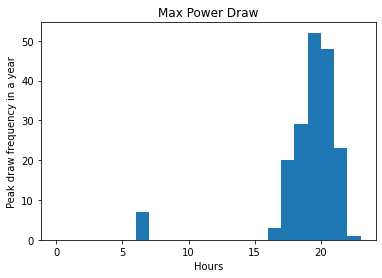

In [26]:
fig1 = make_power_consumption_graph(multi_ny)
fig1.savefig(f'{day}_use.png',bbox_inches='tight')
plt.show()

# Clustering

In [27]:
# from sklearn.preprocessing import MinMaxScaler
# # add minmax scaler

# ny_values = multi_ny.to_numpy()
# scaler = MinMaxScaler(feature_range = (-1,1)) # Fits to (0,1)
# scaler.fit(ny_values)
# ny_norm = scaler.transform(ny_values)
ny_norm = multi_ny_temp.to_numpy()

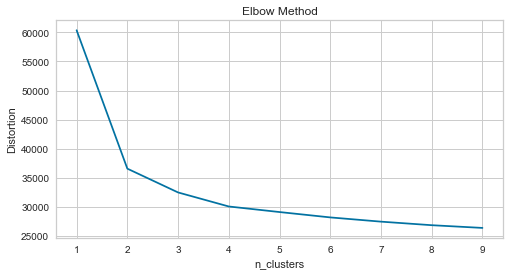

In [48]:
# One way of calculating distortion scores using sklearn
# Used for determining the ideal number of clusters with the elbow method
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny_norm)
    distortions.append(kmeanModel.inertia_) # Inertias and distortions are equivalent, sklearn just calls them inertias
    
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

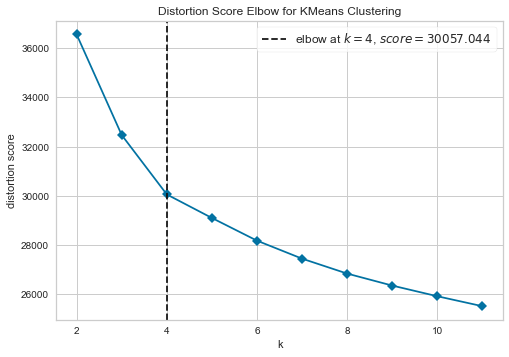

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
# Using yellowbrick to perform the elbow method
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=295) # No need to set number of clusters here

# Visualize distortion scores from k=2 to k=12 clusters
visualizer = KElbowVisualizer(model, k=(2,12),timings=False) # timings=false removes a second line plot of the computation time

visualizer.fit(ny_norm)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure of distortions

C:\Users\orcal\.conda\envs\gurobi\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\orcal\.conda\envs\gurobi\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\orcal\.conda\envs\gurobi\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


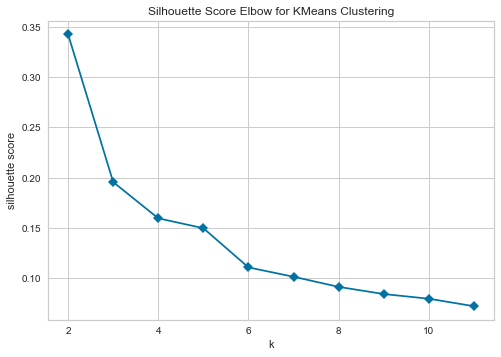

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [30]:
# Use yellowbrick to plot silhouette scores
# We want to select k such that the silhouette score is maximized
visualizer = KElbowVisualizer(model, k=(2,12),metric='silhouette',timings=False)

visualizer.fit(ny_norm)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure of distortions

In [49]:
# Perform kmeans clustering
kmeans = KMeans(n_clusters=2,random_state=295)
kmeans.fit(ny_norm)

KMeans(n_clusters=2, random_state=295)

In [50]:
ny_labels = multi_ny.copy()
ny_labels['kmeans_labels'] = kmeans.labels_

In [51]:
# Show number of times each building was classified into each label
ny_labels.groupby(by=['dataid','kmeans_labels']).size().unstack(fill_value=0)

kmeans_labels,0,1
dataid,,
27,25,158
142,26,157
387,29,154
558,183,0
914,41,142
950,28,155
1222,34,149
1240,183,0
1417,183,0


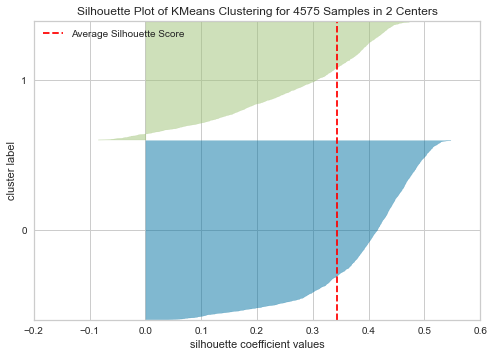

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4575 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
# Use yellowbrick to visualize silhouette scores across each building-day
from yellowbrick.cluster import SilhouetteVisualizer
# is_fitted=True indicates that the KMeans input model is already fitted to our dataset
vis = SilhouetteVisualizer(kmeans, colors='yellowbrick',is_fitted=True)
vis.fit(ny_norm)       
vis.show()        

In [36]:
kmeans.cluster_centers_.shape

(2, 96)

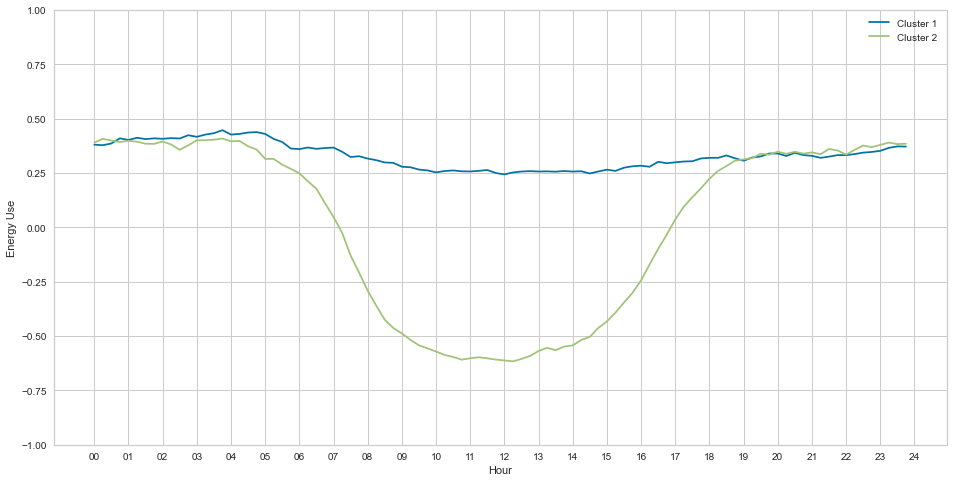

In [37]:
# Plot cluster centers
plt.figure(figsize=(16,8))
for cluster_num in range(kmeans.cluster_centers_.shape[0]):
    plt.plot(kmeans.cluster_centers_[cluster_num,:],label='Cluster '+str(cluster_num+1))

hours = np.arange(25)
hours = [pad_hours(str(hour)) for hour in hours]
plt.xticks(ticks = np.arange(0,kmeans.cluster_centers_.shape[1]+4,4),labels=hours)
plt.xlabel('Hour')
plt.ylabel('Energy Use')
plt.ylim([-1,1])
plt.legend()
plt.show()

In [45]:
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score

# n_components = np.arange(2,12+1)
# n_it = 20
# num_best = 5
# # Average over several fits for each number of clusters to test
# bics = []
# aics = []
# bics_std = []
# aics_std = []
# sils = []
# sils_std = []
# for n in n_components:
#     print(f"{n} components")
#     tmp_bic = []
#     tmp_aic = []
#     tmp_sil = []
#     for it in range(n_it):
#         model = GaussianMixture(n,n_init=2, covariance_type='full').fit(ny_norm)
#         labels = model.predict(ny_norm)
        
#         # Calculate silhouette score for each iteration
#         sil_score=silhouette_score(ny_norm, labels, metric='euclidean')
#         tmp_sil.append(sil_score)
        
#         # Calculate BIC and AIC for each iteration
#         tmp_bic.append(model.bic(ny_norm))
#         tmp_aic.append(model.aic(ny_norm))
    
#     # Take average and std of best n fits
#     best_bics = np.sort(tmp_bic,axis=None)[:num_best]
#     bics.append(np.mean(best_bics))
#     bics_std.append(np.std(best_bics))
    
#     best_aics = np.sort(tmp_aic,axis=None)[:num_best]
#     aics.append(np.mean(best_aics))
#     aics_std.append(np.std(best_aics))
    
#     best_sils = np.sort(tmp_sil,axis=None)[:num_best]
#     sils.append(np.mean(best_sils))
#     sils_std.append(np.std(best_sils))

# # Plot results
# fig, axs = plt.subplots(2, 1,figsize=(14,6))
# axs[0].errorbar(n_components, sils, yerr=sils_std, label='Silhouette')
# axs[0].legend(loc='best')
# axs[0].set_xticks(ticks = n_components)
# axs[0].set_xlabel('n_components')
# axs[0].set_ylabel('Score')
# axs[1].errorbar(n_components, bics, yerr=bics_std, label='BIC')
# axs[1].errorbar(n_components, aics, yerr=aics_std, label='AIC')
# axs[1].legend(loc='best')
# axs[1].set_xticks(ticks = n_components)
# axs[1].set_xlabel('n_components')
# axs[1].set_ylabel('Score')